# Table of content

- <a href='#eda'>Exploratory Data Analysis</a>
  - <a href='#helper-functions'>Helper functions</a>
  - <a href='#population-distribution'>Research question 1: Population distribution vs. wealth and democracy</a>
    - <a href='#top-democratic-countries'>Most democratic countries</a>
    - <a href='#population-and-democracy'>Population and democracy</a>
    - <a href='#population-and-wealth'>Population and wealth</a>
    - <a href='#correlation-population-democracy'>Correlation between population and democracy</a>
  - <a href='#democracy-and-wealth'>Research question 2: Democracy and fuel exports vs. wealth</a>
    - <a href='#wealthiest-countries-regime-type'>Regime types of wealthiest countries</a>
    - <a href='#gpd-share-per-regime-type'>Share of global GDP per regime type</a>
    - <a href='#fuel-exports-authoritarian'>Fuel exports and GDP for authoritarian countries</a>
    - <a href='#correlation-democracy-and-gdp'>Correlation between democracy and wealth</a>
- <a href='#conclusions'>Conclusions</a>
  - <a href='#summary'>Summary</a>
  - <a href='#outlook'>Outlook</a>

<a id='eda'></a>
# Exploratory Data Analysis

We will explore, how the wealth of a country, measured by its GDP per capita,
correlates with its regime type, measured by its democracy index.
We will also take into account, whether fuel exports are an important economic factor,
which could notably contribute to a country's wealth.

<a id='helper-functions'></a>
### Helper functions

We define some helper functions for data analysis.

In [1]:
from common import *

import numpy as np
import pandas as pd

import matplotlib as mpl
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
%load_ext autoreload
%autoreload

In [3]:
figsize_small = (10, 5)
figsize_medium = (15, 7.5)
figsize_big = (20, 10)

In [4]:
def sort_and_rank(df, by:str, ascending = False, rank_col_name = "Rank", rank_start = 1):
    """
    Returns a data frame obtained by sorting the given data frame by the given column.
    It will also have a new column containing the rank of each row in the obtained sorting order.

    :param df: data frame to be sorted
    :param by: column to be sorted by
    :param ascending: sorting order (ascending if True, otherwise descending)
    :param rank_col_name: name of new column containing the rank of each row in the obtained sorting order
    :param rank_start: rank value for the first row (default 1).
    :return: new sorted data frame
    """
    df_res = df.sort_values(by=by, ascending=ascending)
    df_res[rank_col_name] = range(rank_start, rank_start + len(df_res))
    return df_res

In [5]:
def convert_col_astype(df, col_name, target_type):
    """Converts given column of the data frame to the target type."""
    df[col_name] = df[col_name].astype(target_type)

def divide_column_and_adapt_name(df, col_name, divisor, round_decimals=1, name_suffix = None):
    """
    Converts a numerical column of the data frame by dividing it by the given divisor,
    and rounding it to given number of decimals.
    Also adapts the column title by appending the given suffix.

    :return copy of data frame with adapted column
    """
    df_res = df.copy()
    df_res[col_name] = (df_res[col_name] / divisor).round(round_decimals)
    if name_suffix is not None:
        df_res.rename(inplace=True, columns={col_name : f"{col_name}, {name_suffix}"})
    return df_res

def convert_col_to_thousands(df, col_name, round_decimals=1):
    return divide_column_and_adapt_name(df, col_name, 1e3, round_decimals, "in thousands")

def convert_col_to_millions(df, col_name, round_decimals=1):
    return divide_column_and_adapt_name(df, col_name, 1e6, round_decimals, "in millions")

def convert_col_to_billions(df, col_name, round_decimals=1):
    return divide_column_and_adapt_name(df, col_name, 1e9, round_decimals, "in billions")

def convert_col_to_trillions(df, col_name, round_decimals=1):
    return divide_column_and_adapt_name(df, col_name, 1e12, round_decimals, "in trillions")

def divide_series_and_adapt_name(series, divisor, round_decimals=1, name_suffix = None):
    """
    Converts a numerical series by dividing it by the given divisor,
    and rounding it to given number of decimals.
    Also adapts the name by appending the given suffix.
    """
    series = (series / divisor).round(round_decimals)
    if name_suffix is not None:
        series.name = f"{series.name}, {name_suffix}"
    return series

def convert_series_to_thousands(series, round_decimals=6):
    return divide_series_and_adapt_name(series, 1e3, round_decimals, "in thousands")

def convert_series_to_millions(series, round_decimals=6):
    return divide_series_and_adapt_name(series, 1e6, round_decimals, "in millions")

def convert_series_to_billions(series, round_decimals=6):
    return divide_series_and_adapt_name(series, 1e9, round_decimals, "in billions")

def convert_series_to_trillions(series, round_decimals=6):
    return divide_series_and_adapt_name(series, 1e12, round_decimals, "in trillions")

In [6]:
def corrcoef(x, y):
    """
    Convenience method to calculate the Pearson correlation coefficient.

    See also: numpy.corrcoef (https://numpy.org/doc/stable/reference/generated/numpy.corrcoef.html)
    """
    corr_matrix = np.corrcoef([x.values, y.values])
    return corr_matrix[1, 0]

In [7]:
def annotate_bars(ax, series, value_format = ""):
    """
    Annotates the bars of a bar plot with corresponding values.

    Usage example for a Series with float values:
        ``ax = some_series.plot(kind='bar')``

        ``annotate_bars(ax, series, ".2f")``

    :param ax: bar plot, e.g. an AxesSubplot
    :param idx_value_pairs: an iterable containing the pairs (index, value)
    :param value_format: optional string format for the values
    """
    for idx, value in enumerate(series):
        ax.annotate(f"{value:{value_format}}",
                    xy = (idx, value), xytext=(0, 3),
                    textcoords="offset points", ha="center", va="bottom")

    plt.ylim(0, series.max() * 1.1) # leave some space for bar annotations

In [8]:
def plot_bar_annotated(series, title, color = None, annotated_values_format = "",
                       title_font_size = 16, label_font_size = 14, figsize = figsize_small):
    """
    Plots a bar chart for the values in the `series`.

    :param series: Values to be plotted
    :param title: Title of the chart
    :param color: Color for the bars, or list/array of colors with values for each bar
    :param annotated_values_format: optional string format for the values
    :param title_font_size: Font size for the chart title
    :param label_font_size: Font size for the axes labels
    :param figsize size of the figure object
    :return:
    """
    ax = series.plot(kind="bar", color=color, figsize=figsize)
    annotate_bars(ax, series, annotated_values_format)
    plt.title(title, fontsize=title_font_size)
    plt.xlabel(series.index.name, fontsize=label_font_size)
    plt.ylabel(series.name, fontsize=label_font_size);

In [9]:
def plot_pie_annotated(series, title, colors = None, autopct = "",
                       title_font_size = 16, label_font_size = 14, figsize = figsize_small):
    """
    Plots a pie chart for the percentages of the values in the `series`.

    :param series: Values to be plotted
    :param title: Title of the chart
    :param colors: Color for the pie segments, or list/array of colors with values for each pie segment
    :param autopct: optional string format for the percentage values, e.g. "%.1f%%"
    :param title_font_size: Font size for the chart title
    :param label_font_size: Font size for the axes labels
    :param figsize size of the figure object
    """
    series.plot(kind='pie', autopct=autopct, colors=colors, figsize=figsize)
    plt.title(title, fontsize=title_font_size)
    plt.xlabel(series.index.name, fontsize=label_font_size)
    plt.ylabel(""); # no y-axis label

In [10]:
def plot_bars_colored(
        df,
        x_col_name,
        y_col_name,
        legend_labels_and_colors,
        row_to_bar_color_mapper,
        title,
        xlabel,
        ylabel,
        title_font_size = 16,
        label_font_size = 14,
        figsize=figsize_big):
    """
    Plots a bar chart for the given columns in the data frame.
    The bar for each row is given the color calculated by row_to_bar_color_mapper for the row.

    :param df: data frame to be plotted
    :param x_col_name: column to be taken for the x axis, i.e., values for bar labels
    :param y_col_name: column to be taken for the y axis, i.e., values for bar heights
    :param title: Title of the chart
    :param xlabel: label for the x axis
    :param ylabel: label for the y axis
    :param legend_labels_and_colors: legend to be shown: pairs of (label, color)
    :param row_to_bar_color_mapper: function mapping each row of the data frame to a corresponding bar color
    :param title_font_size: Font size for the chart title
    :param label_font_size: Font size for the axes labels
    :param figsize size of the figure object
    """

    legend_labels = [label for (label, color) in legend_labels_and_colors]
    legend_colors = [color for (label, color) in legend_labels_and_colors]
    legend_elements = [Line2D([0], [0], color=color, lw=6) for color in legend_colors]
    bar_colors = df.apply(lambda row: row_to_bar_color_mapper(row), axis = 1)

    df.plot(kind='bar', x=x_col_name, y=y_col_name, color=bar_colors, figsize=figsize)

    y_max = df[y_col_name].max()
    plt.ylim(0, y_max * 1.4) # leave enough space for the legend
    plt.legend(legend_elements, legend_labels)
    plt.title(title, fontsize=title_font_size)
    plt.xlabel(xlabel, fontsize=label_font_size)
    plt.ylabel(ylabel, fontsize=label_font_size);

In [11]:
def plot_scatter(
        df,
        x_col_name,
        y_col_name,
        title,
        xlabel,
        ylabel,
        title_font_size = 16,
        label_font_size = 14,
        figsize=figsize_medium,
        point_colors='c',
        point_sizes=None,
        idx_to_add_labels=None,
        row_to_label_mapper=None):
    """
    A scatter plot for the given columns in the data frame.
    Additionally, the color, size, and indices to be labelled, can be specified for each point representing a row.

    :param df: data frame to be plotted
    :param x_col_name: column to be taken for the x axis
    :param y_col_name: column to be taken for the y axis
    :param title: Title of the chart
    :param xlabel: label for the x axis
    :param ylabel: label for the y axis
    :param title_font_size: Font size for the chart title
    :param label_font_size: Font size for the axes labels
    :param figsize size of the figure object
    :param point_colors: colors for each point representing a row. Can also be a single color name string for all points.
    :param point_sizes: sizes for each point
    :param idx_to_add_labels: indices of points to be annotated with a label containing the index value
    :param row_to_label_mapper: function mapping each row of the data frame to a corresponding label
    :return:
    """

    ax = df.plot(kind='scatter',
            x=ColDem.democracy_index,
            y=ColGdp.gdp_per_capita,
            c=point_colors,
            s=point_sizes,
            figsize=figsize)

    # x_range = df[x_col_name].max() - df[x_col_name].min()
    # y_range = df[y_col_name].max() - df[y_col_name].min()
    if idx_to_add_labels is not None:
        for idx in idx_to_add_labels:
            row = df.loc[idx]
            xval, yval = row[[x_col_name, y_col_name]]
            point_size = 1 if point_sizes is None else point_sizes[idx]
            # try to approximately calculate the offset for the label so that it's close to the point but doesn't overlap with it
            offset = 2 + np.sqrt(point_size) / 3
            label = row_to_label_mapper(row) if row_to_label_mapper is not None else idx
            ax.annotate(label,
                        xy=(xval, yval),
                        xytext=(offset, offset),
                        textcoords="offset pixels", ha="left", va="center")

    plt.title(title, fontsize=title_font_size)
    plt.xlabel(xlabel, fontsize=label_font_size)
    plt.ylabel(ylabel, fontsize=label_font_size);

### Load the prepared data set

We load the data cleaned and prepared for the analysis in the data wrangling notebook
(<a href="02_data_wrangling.ipynb" target="_blank">Jupyter</a> / <a href="02_data_wrangling.html" target="_blank">HTML</a>).

In [12]:
df = pd.read_csv(f"{output_folder}/democracy_and_gdp.csv", index_col=ColGdp.country_code)
df.head()

,Country,Year,GDP per capita (PPP dollars),GDP per capita,Population,Democracy index,Regime type,Fuel exports (% of merchandise exports),GDP total,GDP total (PPP dollars)
Country code,,,,,,,,,,
afg,Afghanistan,2018,1735,493.750418,37172386.0,29.7,Authoritarian,10.213180,1.835388e+10,6.449409e+10
alb,Albania,2018,12306,5284.380184,2866376.0,59.8,Hybrid,1.662666,1.514702e+10,3.527362e+10
dza,Algeria,2018,13886,4153.733978,42228429.0,35.0,Authoritarian,96.111562,1.754057e+11,5.863840e+11
ago,Angola,2018,5725,3289.646664,30809762.0,36.2,Authoritarian,92.417810,1.013532e+11,1.763859e+11
arg,Argentina,2018,18282,11633.498009,44494502.0,70.2,Democracy,4.119375,5.176267e+11,8.134485e+11


<a id='population-distribution'></a>
## Population distribution across countries w. r. t. their wealth and regime type

As our 1st research question we will analyse,
how the total population of the investigated countries
is distributed across countries with respect to the wealth (GDP per capita)
and the regime type (democracy index).

Some questions will be:
- What are the most democratic countries?
- What percentage of global population lives in democratic vs. autocratic countries?
- What percentage of global population lives in wealthy vs. less wealthy countries?
- Is there a correlation between population size and democracy index?

<a id='top-democratic-countries'></a>
### Top 30 most democratic countries

We want to have a look at 30 countries with the highest democracy index.

In [13]:
df1 = convert_col_to_millions(
    df[[ColDem.country, ColDem.democracy_index, ColPop.population, ColGdp.gdp_per_capita]],
    ColPop.population,
    round_decimals=2)
df1 = convert_col_to_thousands(df1, ColGdp.gdp_per_capita)
sort_and_rank(df1, by=ColDem.democracy_index).head(30)

,Country,Democracy index,"Population, in millions","GDP per capita, in thousands",Rank
Country code,,,,,
nor,Norway,98.7,5.31,81.7,1
isl,Iceland,95.8,0.35,73.0,2
swe,Sweden,93.9,10.18,54.6,3
nzl,New Zealand,92.6,4.84,42.9,4
dnk,Denmark,92.2,5.79,61.6,5
irl,Ireland,91.5,4.87,78.6,6
can,Canada,91.5,37.06,46.3,7
fin,Finland,91.4,5.52,50.0,8
aus,Australia,90.9,24.98,57.4,9


Some interesting observations about the top 30 democratic countries:
- The Top 10 include 5 Nordic countries and 4 English-speaking countries
- There are countries from all continents (except Antarctica)
- The Top 30 include both big and small countries
- Most of the countries seem rather wealthy, but there are also some less wealthy ones


<a id='population-and-democracy'></a>
### Population distribution w. r. t. democracy

We want to explore, how many people live in democratic vs. autocratic countries.

In [14]:
pop_by_regime_type = df.groupby(ColDem.regime_type)[ColPop.population].sum()
pop_by_regime_type

Regime type
Authoritarian    2.685213e+09
Democracy        3.601345e+09
Hybrid           1.263182e+09
Name: Population, dtype: float64

In [15]:
pop_percentage_by_regime_type = pop_by_regime_type / pop_by_regime_type.sum() * 100
pop_percentage_by_regime_type

Regime type
Authoritarian    35.566957
Democracy        47.701580
Hybrid           16.731463
Name: Population, dtype: float64

In [16]:
pop_in_bn_by_regime_type = convert_series_to_billions(pop_by_regime_type.reindex(RegimeType.values))
pop_in_bn_by_regime_type

Regime type
Democracy        3.601345
Hybrid           1.263182
Authoritarian    2.685213
Name: Population, in billions, dtype: float64

In [17]:
class ColorRegimeType:
    democracy = "g"
    hybrid = "y"
    authoritarian = "r"
    values = [democracy, hybrid, authoritarian]

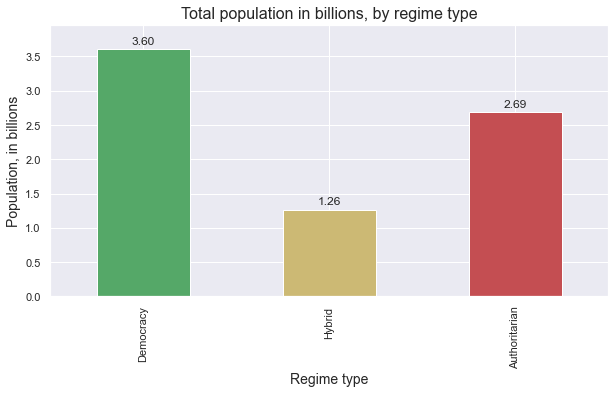

In [18]:
plot_bar_annotated(pop_in_bn_by_regime_type,
                   title="Total population in billions, by regime type",
                   color=ColorRegimeType.values,
                   annotated_values_format=".2f")

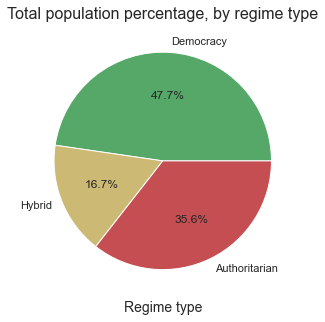

In [19]:
plot_pie_annotated(pop_in_bn_by_regime_type,
                   title="Total population percentage, by regime type",
                   colors=ColorRegimeType.values,
                   autopct='%.1f%%')

The biggest democratic countries:

In [20]:
df[df[ColDem.regime_type] == RegimeType.democracy].sort_values(ColPop.population, ascending=False).head()

,Country,Year,GDP per capita (PPP dollars),GDP per capita,Population,Democracy index,Regime type,Fuel exports (% of merchandise exports),GDP total,GDP total (PPP dollars)
Country code,,,,,,,,,,
ind,India,2018,6899,2005.863005,1.352617e+09,72.3,Democracy,15.067451,2.713165e+12,9.331707e+12
usa,United States,2018,55681,62996.471285,3.266875e+08,79.6,Democracy,13.529994,2.058016e+13,1.819029e+13
idn,Indonesia,2018,11606,3893.846425,2.676634e+08,63.9,Democracy,23.310028,1.042240e+12,3.106502e+12
bra,Brazil,2018,14283,9001.234249,2.094693e+08,69.7,Democracy,12.368601,1.885483e+12,2.991850e+12
jpn,Japan,2018,39294,39159.423563,1.265291e+08,79.9,Democracy,1.810717,4.954807e+12,4.971834e+12


The biggest countries with a hybrid regime:

In [21]:
df[df[ColDem.regime_type] == RegimeType.hybrid].sort_values(ColPop.population, ascending=False).head()

,Country,Year,GDP per capita (PPP dollars),GDP per capita,Population,Democracy index,Regime type,Fuel exports (% of merchandise exports),GDP total,GDP total (PPP dollars)
Country code,,,,,,,,,,
pak,Pakistan,2018,4928,1482.305667,212215030.0,41.7,Hybrid,2.134266,3.145675e+11,1.045796e+12
nga,Nigeria,2018,5316,2027.777979,195874740.0,44.4,Hybrid,94.113782,3.971905e+11,1.041270e+12
bgd,Bangladesh,2018,3879,1698.350394,161356039.0,55.7,Hybrid,0.000000,2.740391e+11,6.259001e+11
tur,Turkey,2018,25287,9455.593654,82319724.0,43.7,Hybrid,2.464243,7.783819e+11,2.081619e+12
tha,Thailand,2018,16905,7295.475616,69428524.0,46.3,Hybrid,4.225474,5.065141e+11,1.173689e+12


The biggest authoritarian countries:

In [22]:
df[df[ColDem.regime_type] == RegimeType.authoritarian].sort_values(ColPop.population, ascending=False).head()

,Country,Year,GDP per capita (PPP dollars),GDP per capita,Population,Democracy index,Regime type,Fuel exports (% of merchandise exports),GDP total,GDP total (PPP dollars)
Country code,,,,,,,,,,
chn,China,2018,16187,9976.677137,1.392730e+09,33.2,Authoritarian,1.869449,1.389482e+13,2.254412e+13
rus,Russia,2018,25367,11370.813456,1.444779e+08,29.4,Authoritarian,52.680834,1.642831e+12,3.664970e+12
eth,Ethiopia,2018,1794,771.523814,1.092246e+08,33.5,Authoritarian,0.000009,8.426935e+10,1.959489e+11
egy,Egypt,2018,11014,2537.125365,9.842360e+07,33.6,Authoritarian,24.565669,2.497130e+11,1.084037e+12
vnm,Vietnam,2018,6609,2566.596950,9.554040e+07,30.8,Authoritarian,1.613913,2.452137e+11,6.314265e+11


We can see that almost 1/2 of the world population lives in democracies,
somewhat more than 1/3 in autocracies (China accounting for more than half of it)
and around 1/6 in hybrid regimes (e.g. some Eastern European countries or Turkey).

<a id='population-and-wealth'></a>
### Population distribution w. r. t.  wealth

We want to explore, how many people live in wealthy vs. less-wealthy countries.

For each country, we have two GDP per capita values: in current USD or in PPP dollars, respectively.
We will consider a country's GDP level as
- _above-average_, if both GDP per capita values are above average
- _around-average_, if only one GDP per capita value is above average
- _below-average_, if both GDP per capita values are below average

The world average GDP per capita (PPP dollars) in 2018 was 15941,
according to the data set [GDP per capita, constant PPP dollars](https://www.gapminder.org/data/documentation/gd001/)
from [Gapminder](https://www.gapminder.org/).

In [23]:
world_avg_gdp_per_capita_ppp = 15941

The world average GDP per capita in 2018 was 11385
according to [GDP per capita (current US$)](https://data.worldbank.org/indicator/NY.GDP.PCAP.CD)
from [World Bank Open Data](https://data.worldbank.org/).

In [24]:
world_avg_gdp_per_capita_current_usd = 11385

We will assign a GDP level to each country, based on whether both, one, or none of the two GDP figures
(in current USD or in PPP dollars, respectively) are above-average.

In [25]:
class GdpLevel:
    above_average = "Above-average"
    around_average = "Around-average"
    below_average = "Below-average"
    values = [above_average, around_average, below_average]

def to_gdp_level(num_of_gdp_indicators_above_avg):
    n = num_of_gdp_indicators_above_avg
    return GdpLevel.above_average if n == 2 \
        else GdpLevel.around_average if n == 1 \
        else GdpLevel.below_average

df[ColGdp.above_avg_gdp_per_capita_ppp] = df[ColGdp.gdp_per_capita_ppp] >= world_avg_gdp_per_capita_ppp
df[ColGdp.above_avg_gdp_per_capita] = df[ColGdp.gdp_per_capita] >= world_avg_gdp_per_capita_current_usd
df[ColGdp.gdp_level] = \
    (df[ColGdp.above_avg_gdp_per_capita_ppp].astype(int) + df[ColGdp.above_avg_gdp_per_capita].astype(int))\
    .map(lambda n: to_gdp_level(n))

df.head()

,Country,Year,GDP per capita (PPP dollars),GDP per capita,Population,Democracy index,Regime type,Fuel exports (% of merchandise exports),GDP total,GDP total (PPP dollars),Above-average GDP per capita (PPP dollars),Above-average GDP per capita,GDP level
Country code,,,,,,,,,,,,,
afg,Afghanistan,2018,1735,493.750418,37172386.0,29.7,Authoritarian,10.213180,1.835388e+10,6.449409e+10,False,False,Below-average
alb,Albania,2018,12306,5284.380184,2866376.0,59.8,Hybrid,1.662666,1.514702e+10,3.527362e+10,False,False,Below-average
dza,Algeria,2018,13886,4153.733978,42228429.0,35.0,Authoritarian,96.111562,1.754057e+11,5.863840e+11,False,False,Below-average
ago,Angola,2018,5725,3289.646664,30809762.0,36.2,Authoritarian,92.417810,1.013532e+11,1.763859e+11,False,False,Below-average
arg,Argentina,2018,18282,11633.498009,44494502.0,70.2,Democracy,4.119375,5.176267e+11,8.134485e+11,True,True,Above-average


We want to find out how many people live in countries with above/around/below-average GDP level.

In [26]:
pop_by_gdp_level = df.groupby(ColGdp.gdp_level)[ColPop.population].sum()
pop_by_gdp_level

GDP level
Above-average     1.265958e+09
Around-average    2.003163e+09
Below-average     4.280620e+09
Name: Population, dtype: float64

In [27]:
pop_percentage_by_gdp_level = pop_by_gdp_level / pop_by_gdp_level.sum() * 100
pop_percentage_by_gdp_level

GDP level
Above-average     16.768227
Around-average    26.532869
Below-average     56.698904
Name: Population, dtype: float64

In [28]:
pop_in_bn_by_gdp_level = convert_series_to_billions(pop_by_gdp_level.reindex(GdpLevel.values))
pop_in_bn_by_gdp_level

GDP level
Above-average     1.265958
Around-average    2.003163
Below-average     4.280620
Name: Population, in billions, dtype: float64

In [29]:
class ColorGdpLevel:
    above_average = "limegreen"
    around_average = "gold"
    below_average = "salmon"
    values = [above_average, around_average, below_average]

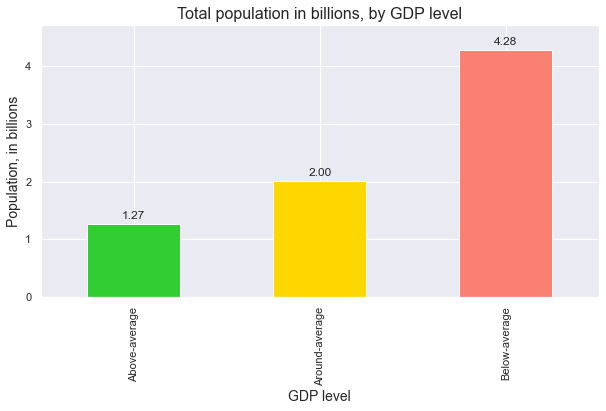

In [30]:
plot_bar_annotated(pop_in_bn_by_gdp_level,
                   title="Total population in billions, by GDP level",
                   color=ColorGdpLevel.values,
                   annotated_values_format=".2f")

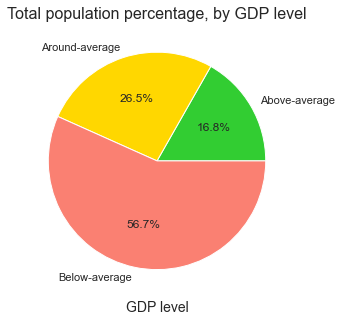

In [31]:
plot_pie_annotated(pop_in_bn_by_gdp_level,
                   title="Total population percentage, by GDP level",
                   colors=ColorGdpLevel.values,
                   autopct='%.1f%%')

The biggest wealthy countries:

In [32]:
def convert_cols_population_gdp(df):
    df_res = df
    df_res = convert_col_to_millions(df_res, ColPop.population, round_decimals=2)
    df_res = convert_col_to_thousands(df_res, ColGdp.gdp_per_capita)
    df_res = convert_col_to_billions(df_res, ColGdp.gdp_total)
    return df_res

In [33]:
col_names = [ColDem.country, ColDem.democracy_index, ColPop.population, ColGdp.gdp_per_capita, ColGdp.gdp_total, ColGdp.gdp_level]

df1 = df[df[ColGdp.gdp_level] == GdpLevel.above_average].sort_values(ColPop.population, ascending=False).head()
convert_cols_population_gdp(df1[col_names])

,Country,Democracy index,"Population, in millions","GDP per capita, in thousands","GDP total, in billions",GDP level
Country code,,,,,,
usa,United States,79.6,326.69,63.0,20580.2,Above-average
jpn,Japan,79.9,126.53,39.2,4954.8,Above-average
deu,Germany,86.8,82.91,47.8,3963.8,Above-average
fra,France,78.0,66.97,41.6,2787.9,Above-average
gbr,United Kingdom,85.3,66.46,43.0,2860.7,Above-average


The biggest countries with GDP level around average:

In [34]:
df1 = df[df[ColGdp.gdp_level] == GdpLevel.around_average].sort_values(ColPop.population, ascending=False).head()
convert_cols_population_gdp(df1[col_names])

,Country,Democracy index,"Population, in millions","GDP per capita, in thousands","GDP total, in billions",GDP level
Country code,,,,,,
chn,China,33.2,1392.73,10.0,13894.8,Around-average
rus,Russia,29.4,144.48,11.4,1642.8,Around-average
mex,Mexico,61.9,126.19,9.7,1222.3,Around-average
tur,Turkey,43.7,82.32,9.5,778.4,Around-average
irn,Iran,24.5,81.80,5.6,454.0,Around-average


The biggest countries with GDP level below average:

In [35]:
df1 = df[df[ColGdp.gdp_level] == GdpLevel.below_average].sort_values(ColPop.population, ascending=False).head()
convert_cols_population_gdp(df1[col_names])

,Country,Democracy index,"Population, in millions","GDP per capita, in thousands","GDP total, in billions",GDP level
Country code,,,,,,
ind,India,72.3,1352.62,2.0,2713.2,Below-average
idn,Indonesia,63.9,267.66,3.9,1042.2,Below-average
pak,Pakistan,41.7,212.22,1.5,314.6,Below-average
bra,Brazil,69.7,209.47,9.0,1885.5,Below-average
nga,Nigeria,44.4,195.87,2.0,397.2,Below-average


We can see that only ca. 1/6 of the world population lives in countries with above-average GDP level
(the biggest 5 countries being USA, Japan, Germany, France, UK)
somewhat more than 1/4 in countries with around-average GDP level
(China accounting for more than half of it)
and more than 1/2 in countries with below-average GDP level
(the biggest 5 countries being India, Indonesia, Pakistan, Brazil, Nigeria).

<a id='correlation-population-democracy'></a>
### Correlation between population and democracy index

We want to check if there is a correlation between the population size of a country and its democracy index.

In [36]:
def plot_bars_colored_by_regime_type(
        df, col_name,
        title, xlabel, ylabel,
        title_font_size = 16, label_font_size = 14, figsize=figsize_big):
    """
    Plots a bar chart for the given column and the regime type in the data frame.
    The bars are colored, depending on the regime type of the country,
    by the colors defined in ColorRegimeType.
    """

    regime_type_to_color_map = {
        RegimeType.democracy : ColorRegimeType.democracy,
        RegimeType.hybrid : ColorRegimeType.hybrid,
        RegimeType.authoritarian : ColorRegimeType.authoritarian }

    plot_bars_colored(
        df,
        x_col_name=ColGdp.country,
        y_col_name=col_name,
        legend_labels_and_colors=[
            (f"{col_name}, {RegimeType.democracy}", ColorRegimeType.democracy),
            (f"{col_name}, {RegimeType.hybrid}", ColorRegimeType.hybrid),
            (f"{col_name}, {RegimeType.authoritarian}", ColorRegimeType.authoritarian)],
        row_to_bar_color_mapper = lambda row: regime_type_to_color_map[row[ColDem.regime_type]],
        title=title,
        xlabel=xlabel,
        ylabel=ylabel,
        title_font_size=title_font_size,
        label_font_size=label_font_size,
        figsize=figsize)

Let's have a look at the 50 most populous countries, colored by the regime type:

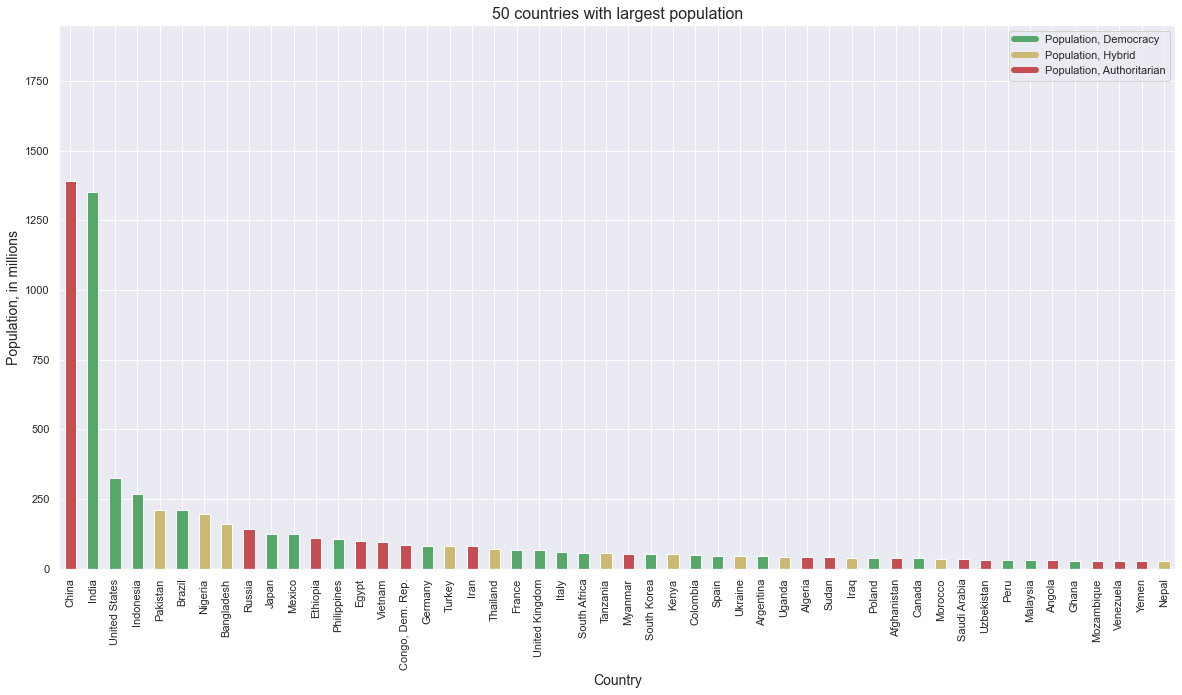

In [37]:
df_pop_millions = df.sort_values(by=ColPop.population, ascending=False)
df_pop_millions[ColPop.population] = df_pop_millions[ColPop.population] / 1e6
num_countries = 50
plot_bars_colored_by_regime_type(
    df_pop_millions.head(num_countries),
    col_name=ColPop.population,
    title=f"{num_countries} countries with largest population",
    xlabel='Country',
    ylabel='Population, in millions')

We can see that the two largest countries, China and India, are authoritarian or democratic, respectively,
i.e., there is no correlation for them. Let's plot the remaining countries:

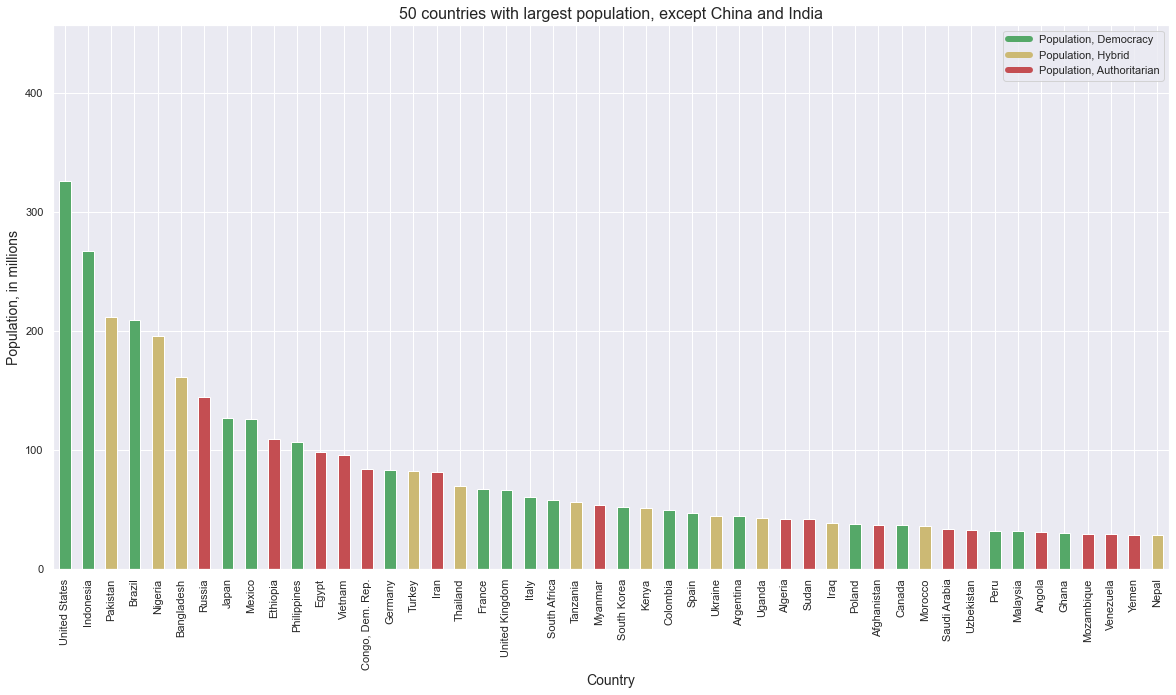

In [38]:
plot_bars_colored_by_regime_type(
    df_pop_millions.iloc[2:].head(num_countries - 2),
    col_name=ColPop.population,
    title=f"{num_countries} countries with largest population, except China and India",
    xlabel='Country',
    ylabel='Population, in millions')

The democratic, hybrid, and authoritarian regime types seem to be mixed without any discernible dependency.
For a last check, we calculate the Pearson correlation coefficient
between population and democracy index.

In [39]:
corrcoef(df[ColPop.population], df[ColDem.democracy_index])

-0.013181752514062924

It turns out that there is no linear correlation between population and democracy index,
because the calculated correlation coefficient is almost 0 (or more exactly, -0.01).


<a id='democracy-and-wealth'></a>
## Democracy index and GDP per capita of countries

As our 2nd research question we will analyse,
how the democracy index of a country correlates with its GDP per capita.

Some questions will be:
- What are the regime types for the wealthiest countries?
- What share of global GDP is produced in each regime type?
- What is the average GDP per capita in each regime type?
- Is there a correlation between GDP per capita and having fuel exports (being "oil-rich") for non-democratic countries?
- Is there a correlation between GDP per capita and democracy index?

<a id='wealthiest-countries-regime-type'></a>
### The regime types of the wealthiest countries

We plot the GDP per capita for 50 wealthiest countries.
The bars are colored according to the regime type.

In [40]:
num_countries = 50

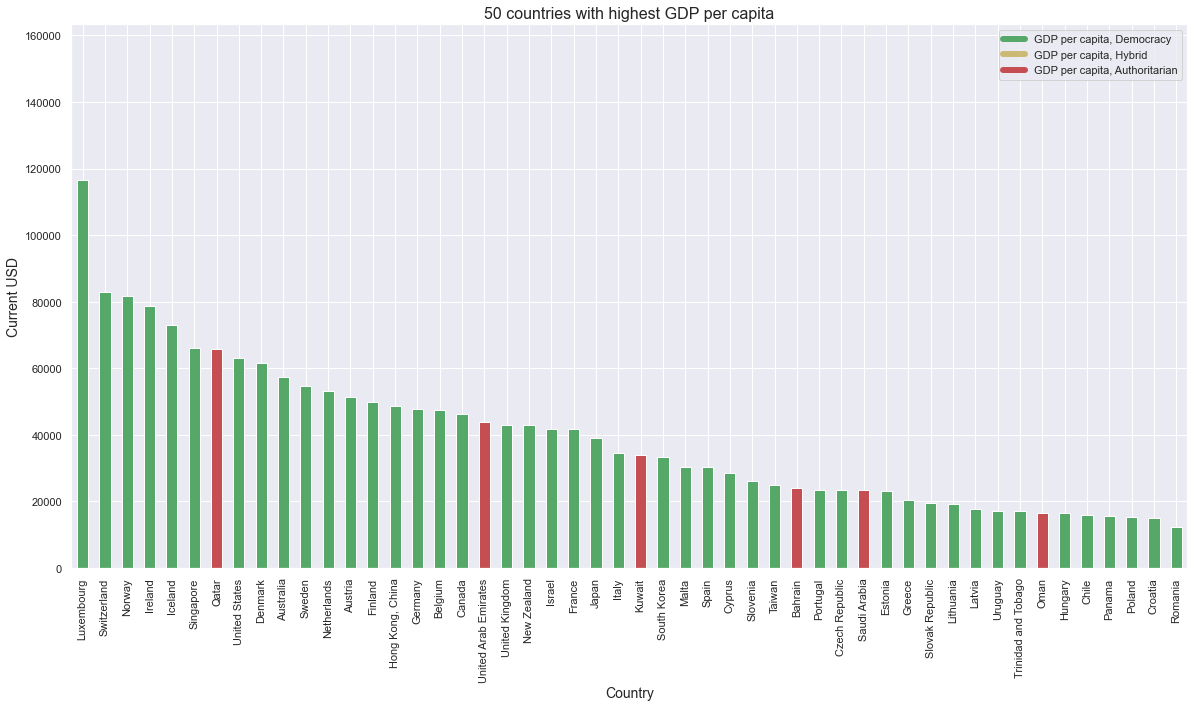

In [41]:
plot_bars_colored_by_regime_type(
    df.sort_values(by=ColGdp.gdp_per_capita, ascending=False).head(num_countries),
    col_name=ColGdp.gdp_per_capita,
    title=f"{num_countries} countries with highest GDP per capita",
    xlabel='Country',
    ylabel='Current USD')

The chart shows that almost all of the 50 wealthiest countries are democracies.
The non-democratic wealthy countries, like Qatar, UAE, seem to be heavy on oil exports.
That's why we now look at the fuel export percentages for the same 50 countries.

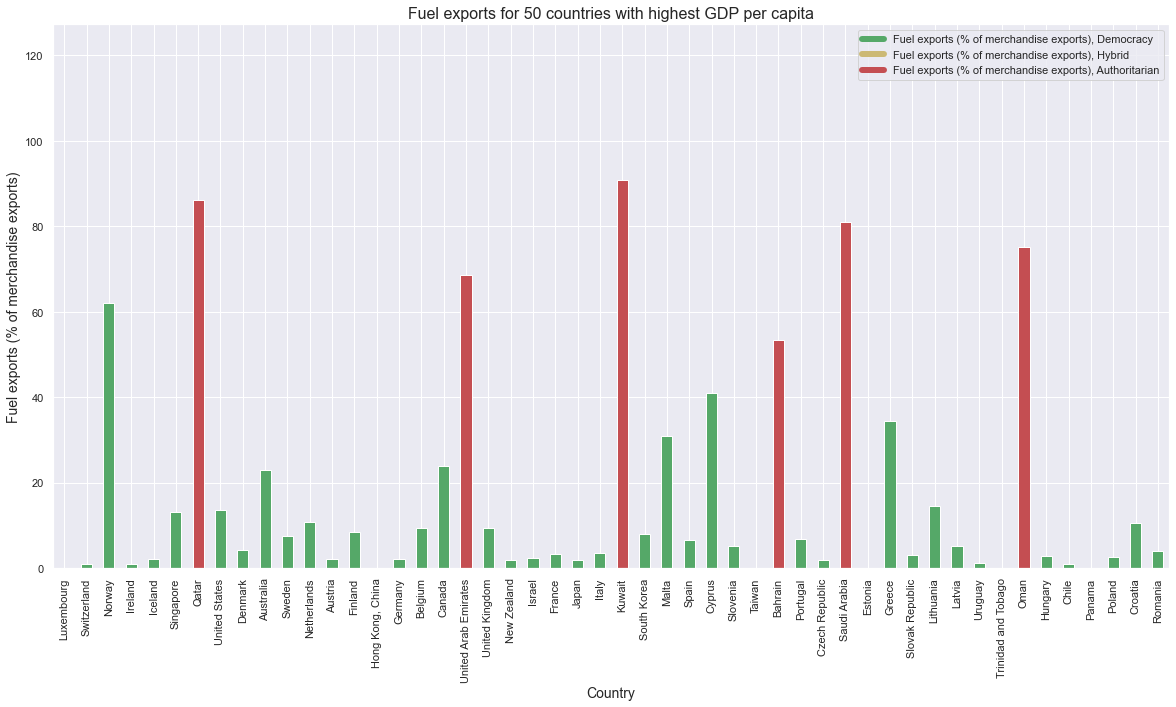

In [42]:
plot_bars_colored_by_regime_type(
    df.sort_values(by=ColGdp.gdp_per_capita, ascending=False).head(num_countries),
    col_name=ColFuel.fuel_exports,
    title=f"Fuel exports for {num_countries} countries with highest GDP per capita",
    xlabel='Country',
    ylabel=ColFuel.fuel_exports)

The chart shows that of the 50 wealthiest countries
- many democratic countries have fuel exports, most of them below 20%, some of them up to 40% of total merchandise exports
- Norway, one of the richest and most democratic countries in the world, has over 60% of fuel exports
- _all_ non-democratic countries have fuel exports of more than 50%, some of them over 80% of total merchandise exports

<a id='autocratic-countries-have-high-gdp-per-capita-only-if-oil-rich'></a>

We can even see that the _only_ non-democratic countries with above-average GDP per capita
are the ones with fuel exports above 50% of merchandise exports:

In [43]:
df1 = df[(df[ColGdp.above_avg_gdp_per_capita]) & (df[ColDem.regime_type] != RegimeType.democracy)]\
    .sort_values(by=ColGdp.gdp_per_capita, ascending=False)
df1 = df1[[ColGdp.country, ColFuel.fuel_exports, ColGdp.gdp_per_capita, ColGdp.gdp_total, ColGdp.gdp_level, ColPop.population,
      ColDem.democracy_index, ColDem.regime_type]]
convert_cols_population_gdp(df1)

,Country,Fuel exports (% of merchandise exports),"GDP per capita, in thousands","GDP total, in billions",GDP level,"Population, in millions",Democracy index,Regime type
Country code,,,,,,,,
qat,Qatar,86.129643,65.9,183.3,Above-average,2.78,31.9,Authoritarian
are,United Arab Emirates,68.554755,43.8,422.2,Above-average,9.63,27.6,Authoritarian
kwt,Kuwait,90.895149,34.0,140.6,Above-average,4.14,38.5,Authoritarian
bhr,Bahrain,53.320392,24.0,37.7,Above-average,1.57,27.1,Authoritarian
sau,Saudi Arabia,81.016984,23.3,786.5,Above-average,33.70,19.3,Authoritarian
omn,Oman,75.185401,16.5,79.8,Above-average,4.83,30.4,Authoritarian


There are no wealthy non-democratic countries with fuel exports below 50% of merchandise exports:

In [44]:
print("Number of wealthy non-democratic countries with fuel exports below 50% of merchandise exports: ",
    ((df[ColGdp.above_avg_gdp_per_capita])
     & (df[ColDem.regime_type] != RegimeType.democracy)
     & (df[ColFuel.fuel_exports] <= 50)).sum())

Number of wealthy non-democratic countries with fuel exports below 50% of merchandise exports:  0


<a id='gpd-share-per-regime-type'></a>
### Share of global GDP produced in each regime type

We group all countries in the data set per regime type,
and plot the percentage of total GDP produced in each regime type.

In [45]:
gdp_by_regime_type = df.groupby(ColDem.regime_type)[ColGdp.gdp_total].sum()
gdp_by_regime_type

Regime type
Authoritarian    1.972747e+13
Democracy        6.242931e+13
Hybrid           3.482402e+12
Name: GDP total, dtype: float64

In [46]:
gdp_percentage_by_regime_type = gdp_by_regime_type / gdp_by_regime_type.sum() * 100
gdp_percentage_by_regime_type

Regime type
Authoritarian    23.035564
Democracy        72.898071
Hybrid            4.066365
Name: GDP total, dtype: float64

In [47]:
gdp_in_tn_by_regime_type = convert_series_to_trillions(gdp_by_regime_type.reindex(RegimeType.values), 2)
gdp_in_tn_by_regime_type

Regime type
Democracy        62.43
Hybrid            3.48
Authoritarian    19.73
Name: GDP total, in trillions, dtype: float64

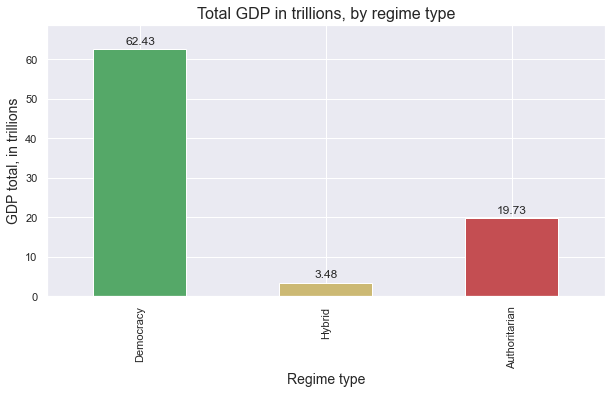

In [48]:
plot_bar_annotated(gdp_in_tn_by_regime_type,
                   title="Total GDP in trillions, by regime type",
                   color=ColorRegimeType.values,
                   annotated_values_format=".2f")

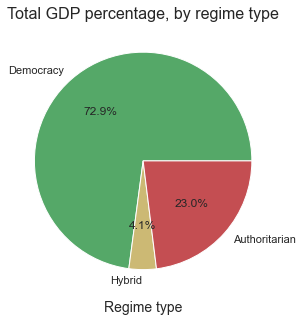

In [49]:
plot_pie_annotated(gdp_in_tn_by_regime_type,
                   title="Total GDP percentage, by regime type",
                   colors=ColorRegimeType.values,
                   autopct='%.1f%%')

More than 70% of the total GDP is produced in democratic countries,
less than 1/4 in autocracies, and less than 5% in countries with hybrid regimes.

### Average GDP per capita in each regime type

We also want to find out the average GDP per capita in each regime type.

In [50]:
average_gdp_per_capita = "Average GDP per capita"
pop_gdp_by_regime_type = df.groupby(ColDem.regime_type)[[ColPop.population, ColGdp.gdp_total]]\
    .sum()\
    .reindex(RegimeType.values)
pop_gdp_by_regime_type[average_gdp_per_capita] = pop_gdp_by_regime_type[ColGdp.gdp_total] / pop_gdp_by_regime_type[ColPop.population]

df1 = pop_gdp_by_regime_type
df1 = convert_col_to_billions(df1, ColPop.population, 2)
df1 = convert_col_to_trillions(df1, ColGdp.gdp_total, 1)
df1 = convert_col_to_thousands(df1, average_gdp_per_capita, 1)
df1

,"Population, in billions","GDP total, in trillions","Average GDP per capita, in thousands"
Regime type,,,
Democracy,3.60,62.4,17.3
Hybrid,1.26,3.5,2.8
Authoritarian,2.69,19.7,7.3


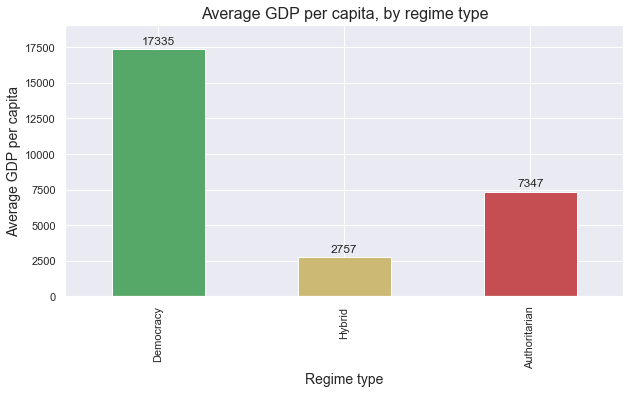

In [51]:
plot_bar_annotated(pop_gdp_by_regime_type[average_gdp_per_capita],
                   title="Average GDP per capita, by regime type",
                   color=ColorRegimeType.values,
                   annotated_values_format=".0f")

It turns out that the average GDP per capita in democracies is more than twice as high as for autocracies.

<a id='fuel-exports-authoritarian'></a>
### Analyze the correlation between fuel exports and GDP per capita for authoritarian countries

We've already seen that the only wealthy non-democratic countries
were the authoritarian ones with fuel exports above 50% of total merchandise exports.
Let's analyze the correlation between fuel exports and wealth specifically for authoritarian countries.

In [52]:
gdp_and_fuel_authoritarian = df[df[ColDem.regime_type] == RegimeType.authoritarian]
gdp_and_fuel_authoritarian.head()

,Country,Year,GDP per capita (PPP dollars),GDP per capita,Population,Democracy index,Regime type,Fuel exports (% of merchandise exports),GDP total,GDP total (PPP dollars),Above-average GDP per capita (PPP dollars),Above-average GDP per capita,GDP level
Country code,,,,,,,,,,,,,
afg,Afghanistan,2018,1735,493.750418,37172386.0,29.7,Authoritarian,10.213180,1.835388e+10,6.449409e+10,False,False,Below-average
dza,Algeria,2018,13886,4153.733978,42228429.0,35.0,Authoritarian,96.111562,1.754057e+11,5.863840e+11,False,False,Below-average
ago,Angola,2018,5725,3289.646664,30809762.0,36.2,Authoritarian,92.417810,1.013532e+11,1.763859e+11,False,False,Below-average
aze,Azerbaijan,2018,16011,4739.841710,9939771.0,26.5,Authoritarian,91.736389,4.711294e+10,1.591457e+11,True,False,Around-average
bhr,Bahrain,2018,41973,23991.056677,1569439.0,27.1,Authoritarian,53.320392,3.765250e+10,6.587406e+10,True,True,Above-average


In [53]:
gdp_and_fuel_authoritarian.info()

<class 'pandas.core.frame.DataFrame'>
Index: 52 entries, afg to zwe
Data columns (total 13 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   Country                                     52 non-null     object 
 1   Year                                        52 non-null     int64  
 2   GDP per capita (PPP dollars)                52 non-null     int64  
 3   GDP per capita                              52 non-null     float64
 4   Population                                  52 non-null     float64
 5   Democracy index                             52 non-null     float64
 6   Regime type                                 52 non-null     object 
 7   Fuel exports (% of merchandise exports)     52 non-null     float64
 8   GDP total                                   52 non-null     float64
 9   GDP total (PPP dollars)                     52 non-null     float64
 10  Above-average GDP 

In [54]:
gdp_and_fuel_authoritarian.describe()

,Year,GDP per capita (PPP dollars),GDP per capita,Population,Democracy index,Fuel exports (% of merchandise exports),GDP total,GDP total (PPP dollars)
count,52.0,52.000000,52.000000,5.200000e+01,52.000000,52.000000,5.200000e+01,5.200000e+01
mean,2018.0,13810.653846,6874.323009,5.163871e+07,28.384615,26.235839,3.793744e+11,7.035955e+11
std,0.0,20675.397239,11951.277742,1.922217e+08,7.609241,34.770884,1.928142e+12,3.143829e+12
min,2018.0,660.000000,271.752044,8.323220e+05,10.800000,0.000000,1.178531e+09,2.092458e+09
25%,2018.0,2352.250000,825.995555,5.699272e+06,21.800000,0.000000,1.300967e+10,2.772118e+10
50%,2018.0,5823.500000,2554.541739,1.235813e+07,30.350000,1.663918,3.972765e+10,6.834786e+10
75%,2018.0,16422.500000,7194.257121,3.134635e+07,33.525000,52.840724,1.003556e+11,2.219985e+11
max,2018.0,112532.000000,65908.066901,1.392730e+09,39.300000,96.111562,1.389482e+13,2.254412e+13


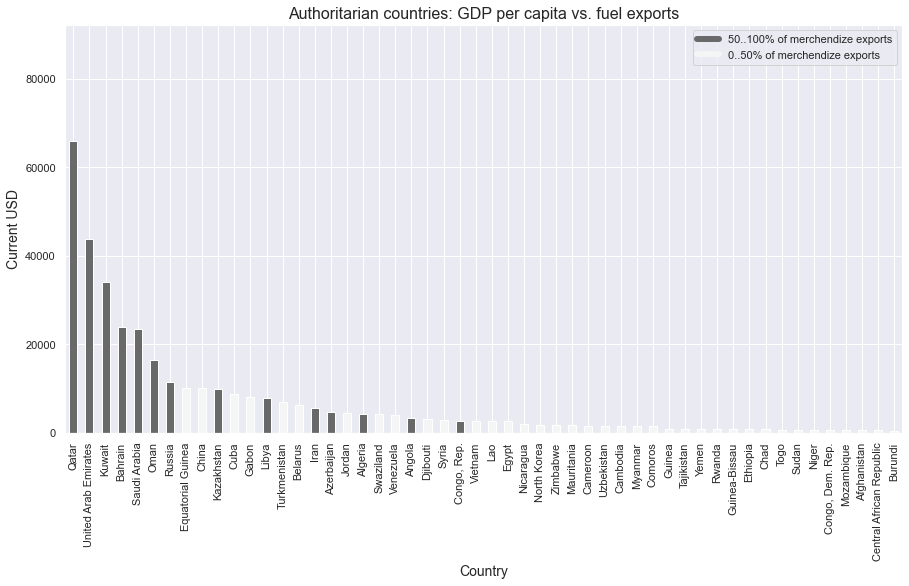

In [55]:
fuel_export_colors = ["whitesmoke", "dimgray"]
fuel_export_color_mapper = lambda percentage: fuel_export_colors[int(percentage / 100 * len(fuel_export_colors))]

plot_bars_colored(
    gdp_and_fuel_authoritarian.sort_values(by=ColGdp.gdp_per_capita, ascending=False),
    x_col_name=ColGdp.country,
    y_col_name=ColGdp.gdp_per_capita,
    legend_labels_and_colors=[
        ("50..100% of merchendize exports", fuel_export_colors[1]),
        ("0..50% of merchendize exports", fuel_export_colors[0])],
    row_to_bar_color_mapper = lambda row: fuel_export_color_mapper(row[ColFuel.fuel_exports]),
    title="Authoritarian countries: GDP per capita vs. fuel exports",
    xlabel='Country',
    ylabel='Current USD',
    figsize=figsize_medium)

The chart show that we can discern 3 groups of countries:
- a top group (Qatar, UAE, Oman, et al) has high GDP per capita,
and the economy is strongly influenced by oil exports,
which make at least 50% of their merchandise export.
- a mixed group (Russia, China, Cuba, Libya, et al) with average or below-average GDP per capita,
where around half of the countries have fuel exports of over 50%.
- a bottom group (Vietnam, Egypt, Nicaragua, et al) that have both low GDP per capita and
not more than 50% of fuel exports (e.g. Egypt with ca 25%),
or even close to none (e.g. Vietnam with 1.6% or Cuba with 0%).

Thus, there seems to be some correlation between fuel exports and wealth in autocracies.
To check for it, we calculate the Pearson correlation coefficient:

In [56]:
corrcoef(gdp_and_fuel_authoritarian[ColGdp.gdp_per_capita], gdp_and_fuel_authoritarian[ColFuel.fuel_exports])

0.5227218609773044

There is a notable correlation of 0.52
between the GDP per capita and the fuel exports in percent of total merchandise exports
for authoritarian countries.

To validate that this effect is specifically relevant for autocracies,
we also check whether there is such a correlation for democratic countries:

In [57]:
gdp_and_fuel_democratic = df[df[ColDem.regime_type] == RegimeType.democracy]
corrcoef(gdp_and_fuel_democratic[ColGdp.gdp_per_capita], gdp_and_fuel_democratic[ColFuel.fuel_exports])

# Note: series of random numbers sometimes produce a correlation around 0.1
# random_series1 = pd.Series(np.random.rand(100))
# random_series2 = pd.Series(np.random.rand(100))
#
# corrcoef(random_series1, random_series2)

-0.0035812043216076417

For democratic countries, the Pearson correlation coefficient
between the GDP per capita and the fuel exports in percent of total merchandise exports
is 0: there is no correlation whatsoever
(it's -0.004, to be very precise, and coefficients with absolute value below 0.1 indicate no correlation,
in fact, even series of random numbers sometimes produce a correlation around 0.1).
This shows that there is indeed a big difference in the influence of fuel exports on the wealth
for authoritarian countries (notable correlation) vs. democratic countries (no correlation).

<a id='correlation-democracy-and-gdp'></a>
### Analyze the correlation between democracy and GDP per capita

Finally, we want to check whether there is a correlation between the
GDP per capita of a country and its democracy index.

We start with a scatter plot for the countries, with democracy index on the x-axis
and the GDP per capita on the y-axis.

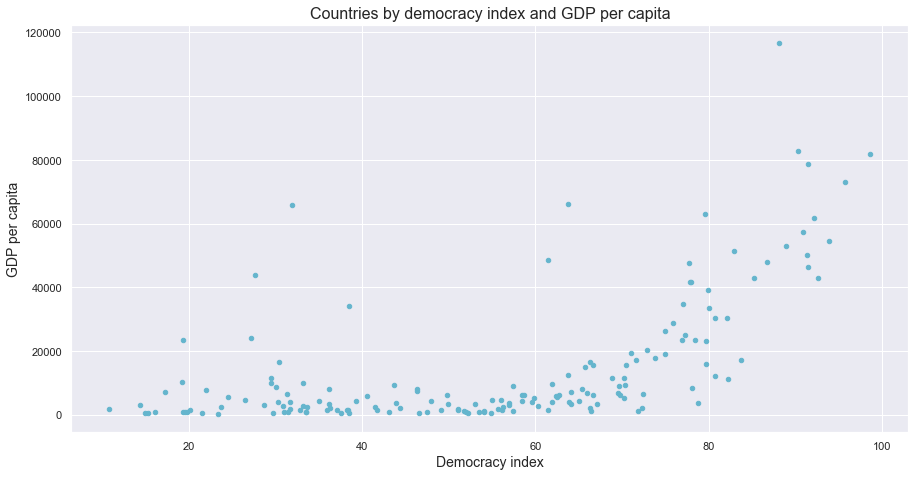

In [58]:
plot_scatter(
    df,
    x_col_name=ColDem.democracy_index,
    y_col_name=ColGdp.gdp_per_capita,
    title="Countries by democracy index and GDP per capita",
    xlabel=ColDem.democracy_index,
    ylabel=ColGdp.gdp_per_capita)

We can see that there is a discernible pattern with the GDP per capita being rather low
till democracy index of 60, and then steadily rising.
On the other hand, we see some outliers of wealthy non-democratic countries:
as we've already found out,
the only non-democratic countries with above-average GDP per capita
are the ones with high fuel exports (see [here](#autocratic-countries-have-high-gdp-per-capita-only-if-oil-rich)).

So, let's have a look at the same scatter plot without the "oil-rich" countries:

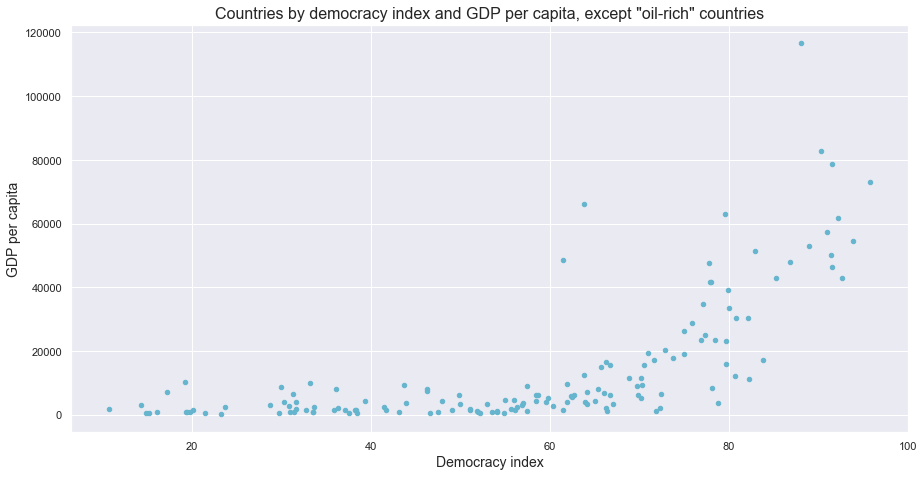

In [59]:
plot_scatter(
    df[df[ColFuel.fuel_exports] < 50],
    x_col_name=ColDem.democracy_index,
    y_col_name=ColGdp.gdp_per_capita,
    title='Countries by democracy index and GDP per capita, except "oil-rich" countries',
    xlabel=ColDem.democracy_index,
    ylabel=ColGdp.gdp_per_capita)

Now we see that _only_ democratic countries (democracy index above 60) have higher GDP per capita values.

For a better overview, we extend the scatter plot to reflect the size of a country.
We will also distinguish "oil-rich" countries
(i.e. with fuel exports of at least 50% of merchandise exports) by a coloring them grey.
Furthermore, we will add labels for a number of countries.

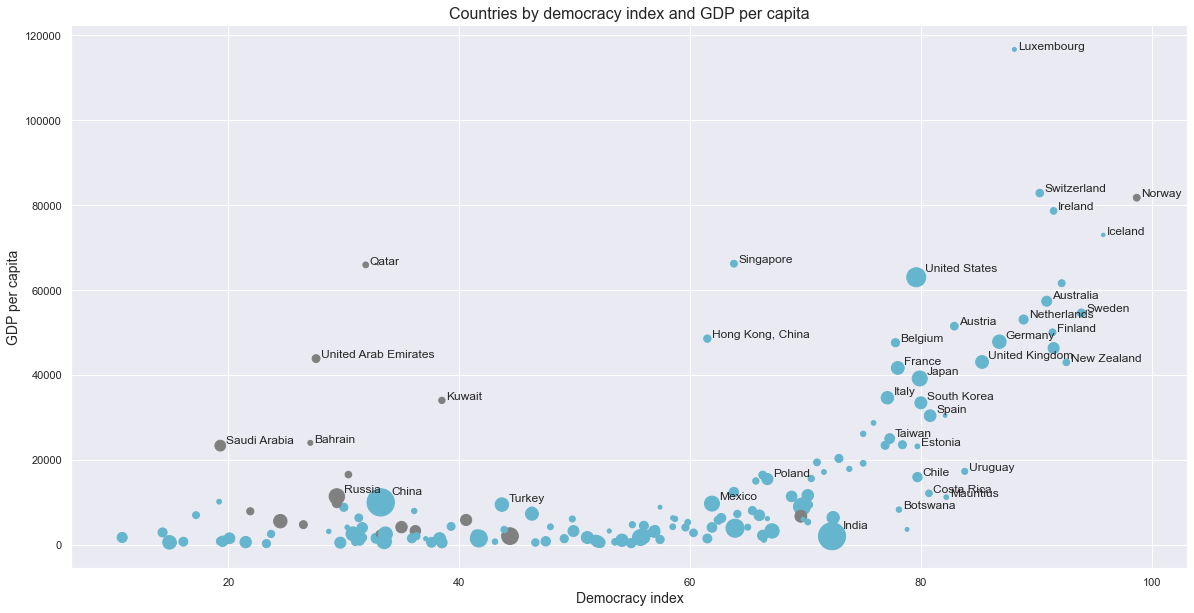

In [60]:
point_sizes = np.sqrt(df[ColPop.population]) / 50
point_colors = df[ColFuel.fuel_exports].map(lambda n: 'grey' if n >= 50 else 'c')
countries_to_add_labels=['are', 'aus', 'aut', 'bel', 'bhr', 'bwa', 'che', 'chl', 'chn', 'cri',
                         'deu', 'esp', 'est', 'fin', 'fra', 'gbr', 'hkg', 'ind', 'irl', 'isl',
                         'ita', 'jpn', 'kor', 'kwt', 'lux', 'mex', 'mus', 'nld', 'nor', 'nzl',
                         'pol', 'rus', 'qat', 'sau', 'sgp', 'swe', 'tur', 'twn', 'ury', 'usa']

plot_scatter(
    df,
    x_col_name=ColDem.democracy_index,
    y_col_name=ColGdp.gdp_per_capita,
    title="Countries by democracy index and GDP per capita",
    xlabel=ColDem.democracy_index,
    ylabel=ColGdp.gdp_per_capita,
    figsize=figsize_big,
    point_colors=point_colors,
    point_sizes=point_sizes,
    idx_to_add_labels=countries_to_add_labels,
    row_to_label_mapper=lambda row: row[ColGdp.country])

It clearly looks like there is a correlation between the democracy and wealth of countries,
with additional influence of fuel exports. To validate these hypotheses, we want to calculate
the Pearson correlation coefficient between democracy index and GDP per capita.

In [61]:
corrcoef(df[ColGdp.gdp_per_capita], df[ColDem.democracy_index])

0.5820800361087862

There is a notable correlation between the GDP per capita and the democracy index.

In [62]:
df_without_oil_rich = df[df[ColFuel.fuel_exports] <= 50]
corrcoef(df_without_oil_rich[ColGdp.gdp_per_capita], df_without_oil_rich[ColDem.democracy_index])

0.6572114348006979

The correlation is even higher if we filter out countries where fuel exports constitute
more than half of merchandise exports.

<a id='conclusions'></a>
# Conclusions

<a id='summary'></a>
## Analysis summary

In this project we investigated data sets on GDP and democracy in 166 countries
that represent over 99% of population and GDP, for which there is freely available data
from [Gapminder](https://www.gapminder.org/free-material/) data sets on
and [World Bank Open Data](https://data.worldbank.org/).

Base on the data for the year 2018,
we have analyzed the wealth of countries, measured by its GDP per capita,
in relation to population, regime type, and fuel exports.
The key results were:
- There is no correlation between the wealth of a country and its population size
- The share of fuel exports in the total merchandise exports of a country
does not correlate with the wealth in democratic countries,
but notably correlates with wealth in authoritarian countries.
- There is a notable correlation between the wealth and the democracy index of countries.
This correlation is even stronger when filtering out the data for the "oil-rich" autocracies,
where merchandise exports have at least 50% of fuel exports.

To sum up, we show the calculated correlation coefficients in the following table:

In [63]:
df_correlations=pd.DataFrame(
    data=[[corrcoef(df[ColPop.population], df[ColDem.democracy_index]),
           "None"],
          [corrcoef(gdp_and_fuel_democratic[ColGdp.gdp_per_capita], gdp_and_fuel_democratic[ColFuel.fuel_exports]),
           "None"],
          [corrcoef(gdp_and_fuel_authoritarian[ColGdp.gdp_per_capita], gdp_and_fuel_authoritarian[ColFuel.fuel_exports]),
           "Notable"],
          [corrcoef(df[ColGdp.gdp_per_capita], df[ColDem.democracy_index]),
           "Notable"],
          [corrcoef(df_without_oil_rich[ColGdp.gdp_per_capita], df_without_oil_rich[ColDem.democracy_index]),
           "Notable to strong"]],
    index=["Population and democracy index",
           "GDP per capita and fuel exports percentage for democratic countries",
           "GDP per capita and fuel exports percentage for authoritarian countries",
           "GDP per capita and democracy index",
           "GDP per capita and democracy index without \"oil-rich\" countries"],
    columns=["Pearson correlation coefficient", "Interpretation of correlation strength"])
df_correlations.iloc[:, 0] = df_correlations.iloc[:, 0].round(2)
df_correlations

,Pearson correlation coefficient,Interpretation of correlation strength
Population and democracy index,-0.01,None
GDP per capita and fuel exports percentage for democratic countries,-0.00,None
GDP per capita and fuel exports percentage for authoritarian countries,0.52,Notable
GDP per capita and democracy index,0.58,Notable
"GDP per capita and democracy index without ""oil-rich"" countries",0.66,Notable to strong


<a id='outlook'></a>
## Outlook

In this project we investigated the data sets on wealth and democracy of countries for on year.
There are a lot more research questions we could consider for future work.

- Differences in wealth/GDP per capita between countries with same regime type:
 - Wealth differences between different groups of authoritarian countries and possible reasons for that, e.g.
fuel exporting countries, China, and all other autocratic countries.
 - What are the differences between countries with hybrid regimes, and what are possible reasons for that.
 - What are the reason for differences in wealth between democratic countries
  - Old vs. young democraticies
  - Influence of authoritarian phases in the country history
  - Geopolitical influences
- How did the wealth and regime type change in recent past, e.g. between 2008 and 2018, or between 2018 and 2021.
- Perform a more fine-grained analysis of wealth based on GDP, e.g.,
differentiate by more than the 3 GDP levels, so that a moderately wealthy country
like Argentina doesn't fall into the same category as rich countries like the USA.
- Ultimately, we could even try out some speculative experimental calculations,
i.e., finding out how the analysis resuls would look like after modifying certain data points,
for example:
 - what if India, the biggest democratic country, reached the GDP level of China, the biggest authoritarian country
 - What if the authoritarian fuel-exporting countries lost there oil/gas-based GDP boost,
which is a possible scenario in a world striving to decarbonize and move away from fossil fuels.

These and many more questions could be possibly investigated in future projects.
